In [29]:
import networkx as nx
import copy
import itertools
import osmnx as ox
import glob
import itertools
from matplotlib import cm
import folium
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
from matplotlib.collections import LineCollection
from osmnx.save_load import graph_to_gdfs
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data, DataLoader
import torch
import pickle


%matplotlib inline
ox.config(log_console=True, use_cache=True, data_folder='')

In [2]:
def plot_graph(G, bbox=None, fig_height=6, fig_width=None, margin=0.02,
               axis_off=True, equal_aspect=False, bgcolor='w', show=True,
               save=False, close=True, file_format='png', filename='temp',
               dpi=300, annotate=False, node_color='#66ccff', node_size=15,
               node_alpha=1, node_edgecolor='none', node_zorder=1,
               edge_color='#999999', edge_linewidth=1, edge_alpha=1, edge_zorder=2,
               use_geom=True):

    #log('Begin plotting the graph...')
    node_Xs = [float(x) for _, x in G.nodes(data='x')]
    node_Ys = [float(y) for _, y in G.nodes(data='y')]

    # get north, south, east, west values either from bbox parameter or from the
    # spatial extent of the edges' geometries
    if bbox is None:
        edges = graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)
        west, south, east, north = edges.total_bounds
    else:
        north, south, east, west = bbox

    # if caller did not pass in a fig_width, calculate it proportionately from
    # the fig_height and bounding box aspect ratio
    bbox_aspect_ratio = (north-south)/(east-west)
    if fig_width is None:
        fig_width = fig_height / bbox_aspect_ratio

    # create the figure and axis
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor=bgcolor)
    ax.set_facecolor(bgcolor)

    # draw the edges as lines from node to node
    start_time = time.time()
    lines = []
    for u, v, data in G.edges(keys=False, data=True):
        if 'geometry' in data and use_geom:
            # if it has a geometry attribute (a list of line segments), add them
            # to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)

    # add the lines to the axis as a linecollection
    if not isinstance(edge_color, list):
        edge_color = [edge_color] * len(lines)
    if not isinstance(edge_linewidth, list):
        edge_linewidth = [edge_linewidth] * len(lines)
    if not isinstance(edge_alpha, list):
        edge_alpha = [edge_alpha] * len(lines)
    if not isinstance(edge_zorder, list):
        edge_zorder = [edge_zorder] * len(lines)
        
    for i in range(len(lines)):
        lc = LineCollection(lines[i:i+1],
                            colors=edge_color[i:i+1],
                            linewidths=edge_linewidth[i:i+1], #TODO FIX!
                            alpha=edge_alpha[i],
                            zorder=edge_zorder[i])
        ax.add_collection(lc)
    #log('Drew the graph edges in {:,.2f} seconds'.format(time.time()-start_time))

    # scatter plot the nodes
    ax.scatter(node_Xs, node_Ys, s=node_size, c=node_color, alpha=node_alpha, edgecolor=node_edgecolor, zorder=node_zorder)

    # set the extent of the figure
    margin_ns = (north - south) * margin
    margin_ew = (east - west) * margin
    ax.set_ylim((south - margin_ns, north + margin_ns))
    ax.set_xlim((west - margin_ew, east + margin_ew))

    # configure axis appearance
    xaxis = ax.get_xaxis()
    yaxis = ax.get_yaxis()

    xaxis.get_major_formatter().set_useOffset(False)
    yaxis.get_major_formatter().set_useOffset(False)

    # if axis_off, turn off the axis display set the margins to zero and point
    # the ticks in so there's no space around the plot
    if axis_off:
        ax.axis('off')
        ax.margins(0)
        ax.tick_params(which='both', direction='in')
        xaxis.set_visible(False)
        yaxis.set_visible(False)
        fig.canvas.draw()

    if equal_aspect:
        # make everything square
        ax.set_aspect('equal')
        fig.canvas.draw()
    else:
        # if the graph is not projected, conform the aspect ratio to not stretch the plot
        if G.graph['crs'] == ox.settings.default_crs:
            coslat = np.cos((min(node_Ys) + max(node_Ys)) / 2. / 180. * np.pi)
            ax.set_aspect(1. / coslat)
            fig.canvas.draw()

    # annotate the axis with node IDs if annotate=True
    if annotate:
        for node, data in G.nodes(data=True):
            ax.annotate(node, xy=(data['x'], data['y']))

    # save and show the figure as specified
    fig, ax = ox.save_and_show(fig, ax, save, show, close, filename, file_format, dpi, axis_off)
    return fig, ax

## Load Graph Data

In [3]:
graph_dir = 'data/boeing_dataverse/06-CA-cities-street_networks-graphml/'
graph_fname = '0667000_San_Francisco.graphml'
CITY_NAME = "san_francisco"

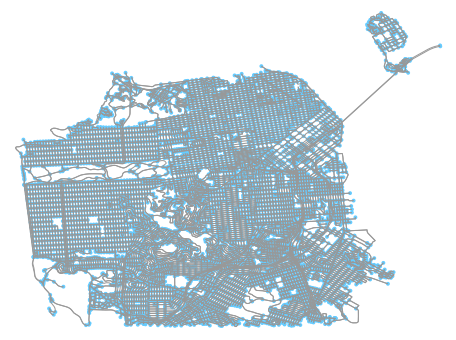

06_CA_0667000_San_Francisco


In [4]:
G = ox.load_graphml(graph_dir + graph_fname)
fig, ax = ox.plot_graph(G)
print(G.graph['name'])

In [5]:
print(G.number_of_nodes())
print(G.number_of_edges())

9367
26324


In [6]:
# osmid column has multiple ids for some roads, this puts single
# ids in a list so that the column has uniform "type" [Int]
def make_uniform_osmid(ids):
    if type(ids) == int:
        return [ids]
    else:
        return ids
    
# lanes are repr as strs and lists of strs, this makes them
# all a single integer representing the max number of lanes
def make_uniform_lanes(lanes):
    if type(lanes) == list:
        return np.mean([float(l) for l in lanes])
    else:
        return float(lanes)
    
def parse_maxspeed(speed):
    if type(speed) == str:
        if speed[-4:] == ' mph':
            return float(speed[:-4])
    return np.NaN
    
gdf_nodes, gdf_edges = ox.save_load.graph_to_gdfs(G)
gdf_edges['osmid'] = gdf_edges['osmid'].map(make_uniform_osmid)
gdf_edges['lanes'] = gdf_edges['lanes'].map(make_uniform_lanes)
gdf_edges['maxspeed'] = gdf_edges['maxspeed'].map(parse_maxspeed)

In [7]:
gdf_nodes.dtypes

y           float64
x           float64
osmid         int64
highway      object
ref          object
geometry     object
dtype: object

In [8]:
gdf_edges.dtypes

u              int64
v              int64
key            int64
osmid         object
bridge        object
oneway          bool
lanes        float64
ref           object
name          object
highway       object
maxspeed     float64
length       float64
geometry    geometry
junction      object
width         object
access        object
tunnel        object
service       object
dtype: object

## Load Movement Data

In [9]:
#fname = "./data/movement_data/movement-speeds-hourly-san-francisco-2019-6.csv.zip"
fname = "./data/movement_data/movement-speeds-quarterly-by-hod-san-francisco-2019-Q2.csv.zip"

%time df_raw = pd.read_csv(fname, engine='c', compression='zip')

CPU times: user 8.53 s, sys: 656 ms, total: 9.18 s
Wall time: 9.24 s


In [10]:
df = df_raw
print("Rows in data: {}".format(len(df)))
df = df[(df['year'] == 2019) &
        (df['quarter'] == 2) &
        (df['hour_of_day'] == 12)]
print("Rows in day data: {}".format(len(df)))

Rows in data: 5474129
Rows in day data: 253627


In [11]:
df.head()

year  quarter  hour_of_day                                segment_id  \
10  2019        2           12  8f4827ebed3c2e66f50daef967d5e91daadd8d98   
37  2019        2           12  aa884b48dd741bb591001ed9d77aaac9f4466048   
53  2019        2           12  f32dbf217023581f429d56330be2a16410bc2809   
70  2019        2           12  9d2084bc7090e387df9866d22b383f2537c40628   
94  2019        2           12  b51e0d015f2a7d9a417746aaae39bbdbfd47a6be   

                           start_junction_id  \
10  8e555723c3dff79036c7a8c0cef6b32a80763c9f   
37  7fe20e98f1cf38b3825fb4cb5bf10a7088834462   
53  8aaf6ad421333ad741cb1d5de1e3fa83e7d0e908   
70  e08d4f15ac0eb1ce777ea2d54efaf6ffa2c3c30e   
94  7c4361ada161cd0725a010cdbd44d0213a6f9efc   

                             end_junction_id  osm_way_id  osm_start_node_id  \
10  2278ad9374ec96c35a0d769bc8a275f6355b55da    40722998           62385707   
37  8bbd97259361a23d374e60e6582019550fc58e0f    87223163         1014244242   
53  8bbd97259361a23d374e60e6582019550fc58e0f   417094233         4714793573   
70  492441475679f95357fbeefc00a9e49c544081c0   416137931          239464357   
94  492441475679f95357fbeefc00a9e49c544081c0   416137931         4169719264   

    osm_end_node_id  speed_mph_mean  speed_mph_stddev  speed_mph_p50  \
10       4927951349          17.793             6.714         18.612   
37       1014244233          22.583             2.306         22.001   
53       1014244233          27.389             4.533         27.706   
70       4318478540          24.707             3.546         24.622   
94       4318478540          26.163             3.917         25.869   

    speed_mph_p85  
10         24.959  
37         25.320  
53         31.219  
70         27.985  
94         29.541

## Join Data

### Inspect Node Overlap

In [12]:
nodes_in_data = set(df['osm_start_node_id']) | set(df['osm_end_node_id'])
print("Movement data for {} nodes".format(len(nodes_in_data)))
nodes_in_graph = set(gdf_nodes['osmid'])
print("Graph data for {} nodes".format(len(nodes_in_graph)))

Movement data for 158218 nodes
Graph data for 9367 nodes


In [13]:
print("intersection: {}".format(len(nodes_in_data & nodes_in_graph)))
print("graph not data: {}".format(len(nodes_in_graph - nodes_in_data)))
print("data not graph: {}".format(len(nodes_in_data - nodes_in_graph)))

intersection: 7465
graph not data: 1902
data not graph: 150753


### Inspect Edge Overlap

In [14]:
edges_in_graph = set([e for es in gdf_edges['osmid'] for e in es])
print("Graph data for {} edges".format(len(edges_in_graph)))
edges_in_data = set(df['osm_way_id'])
print("Movement data for {} edges".format(len(edges_in_data)))

Graph data for 10429 edges
Movement data for 83662 edges


In [15]:
print("intersection: {}".format(len(edges_in_graph & edges_in_data)))
print("graph not data: {}".format(len(edges_in_graph - edges_in_data)))
print("data not graph: {}".format(len(edges_in_data - edges_in_graph)))

intersection: 7993
graph not data: 2436
data not graph: 75669


### Inspect Node Pairs Overlap

In [16]:
pairs_in_graph = set(list(zip(gdf_edges['u'], gdf_edges['v'])))
print("Graph data for {} pairs".format(len(pairs_in_graph)))
pairs_in_data = set(list(zip(df['osm_start_node_id'], df['osm_end_node_id'])))
print("Movement data for {} pairs".format(len(pairs_in_data)))

Graph data for 26248 pairs
Movement data for 253569 pairs


In [17]:
print("intersection: {}".format(len(pairs_in_graph & pairs_in_data)))
print("graph not data: {}".format(len(pairs_in_graph - pairs_in_data)))
print("data not graph: {}".format(len(pairs_in_data - pairs_in_graph)))

intersection: 13344
graph not data: 12904
data not graph: 240225


### Join Data on Edge Overlaps

In [18]:
# expand graph edges dataframe w/ one osmid per row
# note call to DataFrame since explode doesn't seem to work with GeoDataFrame
gdf_expanded_edges = pd.DataFrame(gdf_edges).explode('osmid')
gdf_expanded_edges.head(3)

u          v  key      osmid bridge  oneway  lanes   ref  \
0  32927563  645559609    0   50690291    yes    True    5.0  I 80   
0  32927563  645559609    0  179235221    yes    True    5.0  I 80   
1  32927591  315706881    0   28715659    NaN    True    1.0   NaN   

                                 name        highway  maxspeed    length  \
0  San Francisco – Oakland Bay Bridge       motorway      50.0  3232.317   
0  San Francisco – Oakland Bay Bridge       motorway      50.0  3232.317   
1                                 NaN  motorway_link       NaN   446.491   

                                            geometry junction width access  \
0  LINESTRING (-122.39094 37.78592, -122.39037 37...      NaN   NaN    NaN   
0  LINESTRING (-122.39094 37.78592, -122.39037 37...      NaN   NaN    NaN   
1  LINESTRING (-122.42541 37.73138, -122.42510 37...      NaN   NaN    NaN   

  tunnel service  
0    NaN     NaN  
0    NaN     NaN  
1    NaN     NaN

In [19]:
# merge on osm way ids
gdf_expanded_edges_merged = gdf_expanded_edges.merge(
    df,
    left_on='osmid',
    right_on='osm_way_id',
    how='left')

# take means across duplicate edges
gdf_edges_merged = gdf_expanded_edges_merged.groupby(
    ['u', 'v', 'key']).mean().reset_index()

# merge speeds back into original edge data
gdf_edges_merged = gdf_edges.merge(
    gdf_edges_merged[['u', 'v', 'key',
                      'speed_mph_mean',
                      'speed_mph_stddev',
                      'speed_mph_p50',
                      'speed_mph_p85']],
    on=['u', 'v', 'key'],
    validate='one_to_one')

In [20]:
gdf_edges_merged.head()

u          v  key  \
0  32927563  645559609    0   
1  32927591  315706881    0   
2  32927591  764927373    0   
3  32927645   65331336    0   
4  32927645  766946830    0   

                                               osmid bridge  oneway  lanes  \
0                              [50690291, 179235221]    yes    True    5.0   
1                                         [28715659]    NaN    True    1.0   
2                                         [31487921]    NaN    True    4.0   
3                      [28846637, 8918870, 61424023]    yes    True    2.0   
4  [8915137, 33645923, 33645968, 28656664, 61424026]    yes    True    2.0   

     ref                                name        highway  ...  \
0   I 80  San Francisco – Oakland Bay Bridge       motorway  ...   
1    NaN                                 NaN  motorway_link  ...   
2  I 280                John F Foran Freeway       motorway  ...   
3  I 280        Southern Embarcadero Freeway       motorway  ...   
4    NaN                                 NaN  motorway_link  ...   

                                            geometry  junction width access  \
0  LINESTRING (-122.39094 37.78592, -122.39037 37...       NaN   NaN    NaN   
1  LINESTRING (-122.42541 37.73138, -122.42510 37...       NaN   NaN    NaN   
2  LINESTRING (-122.42541 37.73138, -122.42505 37...       NaN   NaN    NaN   
3  LINESTRING (-122.41331 37.73267, -122.41203 37...       NaN   NaN    NaN   
4  LINESTRING (-122.41331 37.73267, -122.41207 37...       NaN   NaN    NaN   

  tunnel service speed_mph_mean speed_mph_stddev  speed_mph_p50  speed_mph_p85  
0    NaN     NaN      37.106333        10.888000      38.911333      46.936000  
1    NaN     NaN      57.479000         7.715000      56.605000      65.638000  
2    NaN     NaN      66.216000         6.202000      66.853000      72.231000  
3    NaN     NaN      60.663000         6.366333      61.199333      66.522333  
4    NaN     NaN      49.382800        13.333800      53.845200      60.384200  

[5 rows x 22 columns]

In [21]:
gdf_edges_merged.shape

(26324, 22)

In [22]:
gdf_edges.shape

(26324, 18)

In [23]:
print("{}/{} edges have speed data".format(
    (~gdf_edges_merged['speed_mph_mean'].isna()).sum(),
    len(gdf_edges_merged['speed_mph_mean'])))

20584/26324 edges have speed data


## Rebuild Graph and Examine

In [27]:
G = ox.save_load.gdfs_to_graph(gdf_nodes, gdf_edges_merged)

In [25]:
print(len(G))

9367


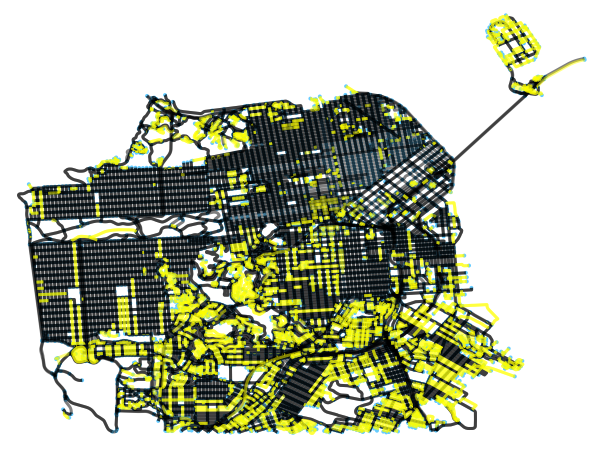

In [88]:
ec = ['black' if 'speed_mph_mean' in d.keys() else 'yellow' for (u,v,d) in G.edges(data=True)]
ez = [3 if 'speed_mph_mean' in d.keys() else 4 for (u,v,d) in G.edges(data=True)]

fig, ax = plot_graph(G, edge_color=ec, fig_height=8,
                     annotate=False, use_geom=True, edge_linewidth=3,
                     edge_alpha=0.5, edge_zorder=ez)

In [120]:
ec = ['yellow' if 'oneway' in d.keys() else 'black' for (u,v,d) in G.edges(data=True)]
ez = [3 if 'oneway' in d.keys() else 4 for (u,v,d) in G.edges(data=True)]

fig, ax = plot_graph(G, edge_color=ec, fig_height=8,
                     annotate=False, use_geom=True, edge_linewidth=3,
                     edge_alpha=0.5, edge_zorder=ez)

In [32]:
#Turn into Line Graph and carry over node and edge attributes
#This cell uses the from_networkx method
G = nx.DiGraph(G)
LG = nx.line_graph(G)
#Possible features for refrence ['speed_mph_p50','speed_mph_p85', 'speed_mph_stddev','speed_mph_mean', 'length', 'lanes', 'oneway']
node_feature_list = ['speed_mph_p85', 'length', 'oneway']
edge_feature_list = ['x','y']

lg_node_attr = {}
node_relabel = {}

IDs = {}
cur_ID = 0

#To make torch_geometric.data extraction easier, remove every node that doesn't have ALL of the features in node_feature_list
remove = []
insert = []
num_train = 24580*0.8
cur_num_train = 0
#seperate into train and test
for key,_ in LG.nodes(data=True):
    new_edge_data = G.get_edge_data(key[0],key[1])
    skip = False
    for k in list(new_edge_data.keys()):
        if k not in node_feature_list:
            del new_edge_data[k]
    for k in node_feature_list:
        if k not in new_edge_data:
            skip = True
            break
    if skip == True:
        remove.append(key)
        continue
    x = []
    edge_x_y = {}
    for k,v in new_edge_data.items():
        if k == 'speed_mph_p85':
            edge_x_y['y'] = [v]
            continue
        x.append(v)
    edge_x_y['x'] = x
    if cur_num_train > num_train:
        edge_x_y['train_mask'] = False
        edge_x_y['test_mask'] = True
    else:
        edge_x_y['train_mask'] = True
        edge_x_y['test_mask'] = False   
    lg_node_attr[cur_ID] = edge_x_y
    node_relabel[key] = cur_ID
    IDs[cur_ID] = key
    cur_ID+=1
    cur_num_train+=1
    
for i in remove:
    LG.remove_node(i)
    
nx.relabel.relabel_nodes(LG,node_relabel,False)
    
nx.set_node_attributes(LG,lg_node_attr)
count = 0
for n in LG.nodes(data=True):
    count+=1
print(count)

nx.set_edge_attributes(LG,{})
for n in LG.nodes(data=True):
    print(n)
    break
print('\n')
for e in LG.edges(data=True):
    print(e)
    break

#nx.write_graphml(LG,'experiments/preprocessed/' + CITY_NAME + ".graphml")

pyData = from_networkx(LG)
index = pyData.edge_index.detach().numpy()
    


20580
(11506, {'y': [16.535750000000004], 'x': [False, 42.948], 'train_mask': True, 'test_mask': False})


(11506, 4845, {})


In [33]:
#Use pyData
print(pyData)
print(pyData.train_mask.sum().item())
print(pyData.num_edge_features)
loader = DataLoader([pyData], batch_size=1)
for batch in loader:
    print(batch)

print(pyData.edge_index.detach().numpy())


Data(edge_index=[2, 60626], test_mask=[20580], train_mask=[20580], x=[20580, 2], y=[20580, 1])
19665
0
Batch(batch=[20580], edge_index=[2, 60626], test_mask=[20580], train_mask=[20580], x=[20580, 2], y=[20580, 1])
[[11506 11506 11506 ...  5513  5513  7851]
 [ 4845  4848  4846 ...  5514  5515  7865]]


In [31]:
#This cell is used to obtain the edge list of the line graph. Does not have proper attributes for nodes and edges.
#The above cell does this
G = nx.DiGraph(G)

LG = nx.line_graph(G)
print(len(LG))
#New Ids are used starting at zero to prevent overflow problem when using snap node2vec
#IDs: 
#key: new ID
#Value: old line graph node key
IDs = {}
cur_ID = 0
node_feature_list = ['speed_mph_p50','speed_mph_p85', 'speed_mph_stddev','speed_mph_mean', 'length', 'oneway']
edge_feature_list = ['x','y']

lg_node_attr = {}
node_relabel = {}

remove = []
insert = []
#seperate into train and test
for key,_ in LG.nodes(data=True):
    new_edge_data = G.get_edge_data(key[0],key[1])
    skip = False
    for k in list(new_edge_data.keys()):
        if k not in node_feature_list:
            del new_edge_data[k]
    for k in node_feature_list:
        if k not in new_edge_data:
            skip = True
            break
    if skip == True:
        remove.append(key)
        continue
    lg_node_attr[cur_ID] = new_edge_data
    node_relabel[key] = cur_ID
    IDs[cur_ID] = key
    cur_ID+=1
    
for i in remove:
    LG.remove_node(i)
#lg_node_attr = {}
#node_relabel = {}
#previous = []
#new = []
#for key,_ in LG.nodes(data=True):
#    previous.append(key)
#    new.append(str(key))
#    node_relabel[key] = cur_ID
#    lg_node_attr[cur_ID] = G.get_edge_data(key[0],key[1])
#   IDs[cur_ID] = key
#    cur_ID+=1
    

nx.relabel.relabel_nodes(LG,node_relabel,False)
    
nx.set_node_attributes(LG,lg_node_attr)
for n in LG.nodes(data=True):    
    print(n)
for e in LG.edges(data=True):    
    print(e)
#nx.write_graphml(LG,'experiments/preprocessed/' + CITY_NAME + ".graphml")
pickle_out = open('./experiments/line_graphs/SF_LG'+".pkl", "wb")
pickle.dump(LG, pickle_out)
pickle_out.close()

26248
(11506, {'oneway': False, 'length': 42.948, 'speed_mph_mean': 13.936, 'speed_mph_stddev': 3.7220000000000004, 'speed_mph_p50': 13.69, 'speed_mph_p85': 16.535750000000004})
(9922, {'oneway': False, 'length': 82.589, 'speed_mph_mean': 19.871149999999997, 'speed_mph_stddev': 3.3949499999999992, 'speed_mph_p50': 19.924850000000003, 'speed_mph_p85': 23.18855})
(493, {'oneway': False, 'length': 404.286, 'speed_mph_mean': 22.835857142857144, 'speed_mph_stddev': 5.144714285714286, 'speed_mph_p50': 22.531, 'speed_mph_p85': 27.287142857142857})
(20532, {'oneway': True, 'length': 189.761, 'speed_mph_mean': 17.87175, 'speed_mph_stddev': 7.27925, 'speed_mph_p50': 18.803, 'speed_mph_p85': 24.91075})
(6405, {'oneway': False, 'length': 13.13, 'speed_mph_mean': 16.593333333333334, 'speed_mph_stddev': 6.045055555555554, 'speed_mph_p50': 16.23061111111111, 'speed_mph_p85': 22.70938888888889})
(19315, {'oneway': False, 'length': 67.469, 'speed_mph_mean': 20.470750000000002, 'speed_mph_stddev': 3.281

(15416, {'oneway': False, 'length': 26.631, 'speed_mph_mean': 14.3735, 'speed_mph_stddev': 4.218500000000001, 'speed_mph_p50': 14.7125, 'speed_mph_p85': 18.104})
(10293, {'oneway': False, 'length': 54.735, 'speed_mph_mean': 19.753687499999998, 'speed_mph_stddev': 3.7261874999999995, 'speed_mph_p50': 19.877125, 'speed_mph_p85': 23.2636875})
(3843, {'oneway': False, 'length': 79.583, 'speed_mph_mean': 15.202999999999998, 'speed_mph_stddev': 5.6014, 'speed_mph_p50': 15.15, 'speed_mph_p85': 20.7262})
(17170, {'oneway': False, 'length': 20.43, 'speed_mph_mean': 13.273, 'speed_mph_stddev': 3.964, 'speed_mph_p50': 13.144, 'speed_mph_p85': 17.002499999999998})
(6312, {'oneway': False, 'length': 94.31, 'speed_mph_mean': 16.514904761904763, 'speed_mph_stddev': 3.3226190476190474, 'speed_mph_p50': 16.441142857142857, 'speed_mph_p85': 19.767857142857142})
(15829, {'oneway': True, 'length': 146.62499999999997, 'speed_mph_mean': 23.143, 'speed_mph_stddev': 7.867999999999999, 'speed_mph_p50': 24.726,

(16068, {'oneway': False, 'length': 102.913, 'speed_mph_mean': 12.3709375, 'speed_mph_stddev': 6.2493125, 'speed_mph_p50': 11.437875, 'speed_mph_p85': 19.278624999999998})
(4490, {'oneway': False, 'length': 54.266999999999996, 'speed_mph_mean': 16.7845, 'speed_mph_stddev': 4.87725, 'speed_mph_p50': 16.4725, 'speed_mph_p85': 21.14775})
(11095, {'oneway': False, 'length': 94.744, 'speed_mph_mean': 27.234299999999998, 'speed_mph_stddev': 6.736400000000001, 'speed_mph_p50': 26.847900000000003, 'speed_mph_p85': 34.409000000000006})
(17652, {'oneway': False, 'length': 71.324, 'speed_mph_mean': 15.010416666666664, 'speed_mph_stddev': 3.069833333333334, 'speed_mph_p50': 14.77375, 'speed_mph_p85': 17.91183333333333})
(12727, {'oneway': True, 'length': 53.19700000000001, 'speed_mph_mean': 12.1055, 'speed_mph_stddev': 4.588, 'speed_mph_p50': 12.5525, 'speed_mph_p85': 17.006})
(5688, {'oneway': False, 'length': 83.699, 'speed_mph_mean': 13.493000000000002, 'speed_mph_stddev': 2.2337499999999997, '

(368, {'oneway': False, 'length': 81.699, 'speed_mph_mean': 16.547, 'speed_mph_stddev': 3.089, 'speed_mph_p50': 16.055, 'speed_mph_p85': 19.003})
(8577, {'oneway': False, 'length': 146.38, 'speed_mph_mean': 16.12675, 'speed_mph_stddev': 6.51, 'speed_mph_p50': 15.42225, 'speed_mph_p85': 23.512})
(15356, {'oneway': True, 'length': 125.07400000000001, 'speed_mph_mean': 20.545333333333335, 'speed_mph_stddev': 6.008333333333333, 'speed_mph_p50': 19.972333333333335, 'speed_mph_p85': 26.982333333333333})
(2690, {'oneway': False, 'length': 63.672, 'speed_mph_mean': 21.743687500000004, 'speed_mph_stddev': 3.9046874999999996, 'speed_mph_p50': 21.9195, 'speed_mph_p85': 25.401437500000004})
(19658, {'oneway': False, 'length': 181.879, 'speed_mph_mean': 16.385166666666667, 'speed_mph_stddev': 5.365333333333333, 'speed_mph_p50': 16.330333333333336, 'speed_mph_p85': 20.4665})
(18836, {'oneway': False, 'length': 19.525, 'speed_mph_mean': 15.24, 'speed_mph_stddev': 2.5780000000000003, 'speed_mph_p50': 

(17159, {'oneway': True, 'length': 10.049, 'speed_mph_mean': 15.417, 'speed_mph_stddev': 8.03, 'speed_mph_p50': 15.767999999999999, 'speed_mph_p85': 23.963})
(20283, {'oneway': False, 'length': 36.919, 'speed_mph_mean': 18.965857142857146, 'speed_mph_stddev': 2.738285714285714, 'speed_mph_p50': 19.173, 'speed_mph_p85': 21.170142857142856})
(6841, {'oneway': False, 'length': 207.45999999999998, 'speed_mph_mean': 17.284631578947373, 'speed_mph_stddev': 3.0863684210526316, 'speed_mph_p50': 17.41073684210526, 'speed_mph_p85': 19.949052631578947})
(6329, {'oneway': False, 'length': 207.519, 'speed_mph_mean': 17.884285714285713, 'speed_mph_stddev': 2.985714285714286, 'speed_mph_p50': 18.354999999999997, 'speed_mph_p85': 20.256285714285717})
(13191, {'oneway': False, 'length': 1.171, 'speed_mph_mean': 17.361, 'speed_mph_stddev': 5.6905, 'speed_mph_p50': 16.5175, 'speed_mph_p85': 23.887999999999998})
(15168, {'oneway': True, 'length': 166.155, 'speed_mph_mean': 11.007, 'speed_mph_stddev': 2.35

(16591, {'oneway': False, 'length': 208.293, 'speed_mph_mean': 23.88925, 'speed_mph_stddev': 3.73925, 'speed_mph_p50': 24.0665, 'speed_mph_p85': 27.364})
(1983, {'oneway': False, 'length': 207.218, 'speed_mph_mean': 18.00571428571428, 'speed_mph_stddev': 2.6991428571428573, 'speed_mph_p50': 18.158142857142856, 'speed_mph_p85': 20.278571428571432})
(5520, {'oneway': False, 'length': 100.957, 'speed_mph_mean': 23.85175, 'speed_mph_stddev': 3.324, 'speed_mph_p50': 24.119, 'speed_mph_p85': 27.10625})
(19284, {'oneway': False, 'length': 146.312, 'speed_mph_mean': 14.85875, 'speed_mph_stddev': 6.086375, 'speed_mph_p50': 14.678000000000003, 'speed_mph_p85': 21.117250000000002})
(15142, {'oneway': True, 'length': 104.77900000000001, 'speed_mph_mean': 15.1368, 'speed_mph_stddev': 7.446000000000001, 'speed_mph_p50': 14.855399999999998, 'speed_mph_p85': 23.247999999999998})
(14270, {'oneway': True, 'length': 14.990000000000002, 'speed_mph_mean': 20.438000000000002, 'speed_mph_stddev': 5.791499999

(5963, {'oneway': False, 'length': 77.87599999999999, 'speed_mph_mean': 18.965857142857146, 'speed_mph_stddev': 2.738285714285714, 'speed_mph_p50': 19.173, 'speed_mph_p85': 21.170142857142856})
(7900, {'oneway': True, 'length': 49.13, 'speed_mph_mean': 9.537, 'speed_mph_stddev': 2.94, 'speed_mph_p50': 9.597999999999999, 'speed_mph_p85': 11.944})
(2332, {'oneway': False, 'length': 94.196, 'speed_mph_mean': 17.491058823529414, 'speed_mph_stddev': 3.017764705882353, 'speed_mph_p50': 17.331235294117647, 'speed_mph_p85': 20.455705882352945})
(14555, {'oneway': False, 'length': 135.022, 'speed_mph_mean': 15.15176923076923, 'speed_mph_stddev': 3.2146153846153847, 'speed_mph_p50': 15.083846153846155, 'speed_mph_p85': 17.992153846153847})
(7462, {'oneway': False, 'length': 94.357, 'speed_mph_mean': 15.191147058823526, 'speed_mph_stddev': 4.310117647058824, 'speed_mph_p50': 15.257264705882351, 'speed_mph_p85': 18.84267647058823})
(11185, {'oneway': False, 'length': 81.384, 'speed_mph_mean': 13.5

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(13600, 13593, {})
(13600, 13592, {})
(8348, 7038, {})
(8348, 7039, {})
(8348, 7040, {})
(8348, 7041, {})
(15754, 20567, {})
(8945, 10222, {})
(8945, 10221, {})
(4960, 17276, {})
(4960, 17273, {})
(4960, 17275, {})
(4960, 17274, {})
(5790, 5774, {})
(5790, 5772, {})
(5790, 5773, {})
(5790, 5771, {})
(14683, 6430, {})
(14683, 6432, {})
(14683, 6431, {})
(14683, 6429, {})
(7513, 12816, {})
(7513, 12817, {})
(7513, 12815, {})
(7513, 12818, {})
(2011, 2019, {})
(2011, 2021, {})
(2011, 2020, {})
(8911, 8929, {})
(8911, 8931, {})
(8911, 8930, {})
(11539, 11543, {})
(11539, 11545, {})
(11539, 11544, {})
(11818, 11963, {})
(11818, 11962, {})
(2314, 8485, {})
(2314, 8486, {})
(2314, 8484, {})
(19536, 19435, {})
(19536, 19434, {})
(15465, 19568, {})
(15465, 19567, {})
(19538, 19537, {})
(19538, 19540, {})
(812, 809, {})
(14321, 14327, {})
(14321, 14329, {})
(14321, 14326, {})
(14321, 14328, {})
(534, 536, {})
(534, 535, {})
(534, 537, {})
(13344, 1301, {})
(13344, 1299, {})
(13344, 1300, {})
(13

(13686, 13671, {})
(13686, 13673, {})
(14114, 14122, {})
(14114, 14121, {})
(14114, 14123, {})
(14114, 14120, {})
(37, 19754, {})
(37, 19756, {})
(37, 19755, {})
(3376, 5359, {})
(3376, 5360, {})
(3376, 5358, {})
(18876, 16456, {})
(18876, 16458, {})
(18876, 16459, {})
(18876, 16457, {})
(3257, 3258, {})
(3257, 3244, {})
(3257, 3253, {})
(3257, 3249, {})
(7861, 7869, {})
(7861, 7867, {})
(7861, 7866, {})
(7861, 7868, {})
(8755, 9426, {})
(8755, 9425, {})
(14843, 5112, {})
(14843, 5114, {})
(14843, 5115, {})
(14843, 5113, {})
(13290, 13291, {})
(13290, 13292, {})
(13290, 13293, {})
(20505, 20113, {})
(12552, 12555, {})
(12552, 12554, {})
(12552, 12553, {})
(839, 841, {})
(839, 840, {})
(13130, 13133, {})
(13130, 13129, {})
(13130, 13137, {})
(13130, 13131, {})
(6577, 6585, {})
(6577, 6584, {})
(6577, 6583, {})
(6577, 6586, {})
(18755, 15378, {})
(18755, 15376, {})
(18755, 15377, {})
(15271, 15270, {})
(15271, 15274, {})
(3459, 3465, {})
(3459, 3463, {})
(3459, 3464, {})
(3459, 3462, {})

(17816, 15782, {})
(17816, 15781, {})
(17816, 15780, {})
(17816, 15779, {})
(430, 19881, {})
(430, 19882, {})
(430, 19883, {})
(16849, 14838, {})
(16849, 14837, {})
(16849, 14836, {})
(8204, 8209, {})
(8204, 8210, {})
(8204, 8208, {})
(8204, 8207, {})
(10990, 17142, {})
(10990, 17141, {})
(19607, 12017, {})
(19607, 12018, {})
(19607, 12019, {})
(17439, 17442, {})
(17439, 17446, {})
(17439, 17438, {})
(17439, 17450, {})
(18193, 19875, {})
(18193, 19874, {})
(2278, 17171, {})
(2278, 17172, {})
(2278, 17173, {})
(2913, 2920, {})
(2913, 2921, {})
(2913, 2923, {})
(2913, 2922, {})
(1800, 1803, {})
(1800, 1802, {})
(1800, 1801, {})
(4065, 4052, {})
(4065, 4051, {})
(9646, 9638, {})
(9646, 9637, {})
(9646, 9636, {})
(6219, 6228, {})
(6219, 6229, {})
(6219, 6227, {})
(6219, 6230, {})
(9636, 9644, {})
(9636, 9645, {})
(9636, 9646, {})
(9636, 9643, {})
(18648, 18149, {})
(18648, 18150, {})
(17561, 12983, {})
(17561, 12985, {})
(17561, 12984, {})
(17385, 17386, {})
(8804, 1010, {})
(8804, 1009, {

(1407, 1412, {})
(11806, 11802, {})
(11806, 11804, {})
(11806, 11803, {})
(5281, 10662, {})
(5281, 10663, {})
(5281, 10664, {})
(18971, 18963, {})
(18971, 18964, {})
(13448, 13443, {})
(13448, 13444, {})
(13448, 13445, {})
(12306, 12304, {})
(3091, 3090, {})
(7980, 12184, {})
(7980, 12183, {})
(7980, 12186, {})
(7980, 12185, {})
(3729, 3735, {})
(3729, 3734, {})
(3729, 3736, {})
(3729, 3737, {})
(8367, 19582, {})
(8367, 19583, {})
(10807, 16761, {})
(10807, 16763, {})
(10807, 16760, {})
(10807, 16762, {})
(20142, 20133, {})
(20142, 20135, {})
(20142, 20134, {})
(8974, 4655, {})
(8974, 4654, {})
(13138, 13141, {})
(13138, 13142, {})
(5505, 6187, {})
(5505, 6188, {})
(5505, 6189, {})
(5505, 6190, {})
(3967, 3975, {})
(3967, 3976, {})
(3967, 3977, {})
(3967, 3978, {})
(3, 4, {})
(18250, 18251, {})
(12112, 12114, {})
(12112, 12115, {})
(13492, 13487, {})
(13492, 13488, {})
(13492, 13489, {})
(1933, 16455, {})
(1933, 16454, {})
(9312, 9313, {})
(9312, 9310, {})
(9312, 9308, {})
(9312, 9309,

(8870, 8874, {})
(8870, 8872, {})
(8870, 8873, {})
(8870, 8871, {})
(6265, 6271, {})
(6265, 6272, {})
(6265, 6274, {})
(6265, 6273, {})
(12889, 12895, {})
(12889, 12894, {})
(12889, 12893, {})
(12889, 12892, {})
(9665, 9678, {})
(9665, 9675, {})
(9665, 9676, {})
(9665, 9677, {})
(19673, 19675, {})
(19673, 19674, {})
(11121, 11154, {})
(7117, 7111, {})
(7117, 7113, {})
(7117, 7114, {})
(7117, 7112, {})
(19714, 11843, {})
(19714, 11842, {})
(19714, 11844, {})
(11124, 11125, {})
(11985, 664, {})
(11985, 667, {})
(11985, 665, {})
(11985, 666, {})
(1613, 1611, {})
(1613, 1610, {})
(14523, 14525, {})
(14523, 14526, {})
(14523, 14527, {})
(10892, 10889, {})
(10892, 10886, {})
(10892, 10893, {})
(18542, 10577, {})
(18542, 10578, {})
(18542, 10576, {})
(18542, 10575, {})
(19814, 18988, {})
(20234, 302, {})
(20234, 301, {})
(20234, 303, {})
(20234, 304, {})
(14800, 11108, {})
(14800, 11106, {})
(14800, 11107, {})
(14800, 11105, {})
(7764, 4039, {})
(7764, 4040, {})
(7764, 4041, {})
(18776, 6015,

(9941, 8792, {})
(9941, 8795, {})
(9941, 8793, {})
(3755, 5751, {})
(3755, 5752, {})
(3755, 5753, {})
(15858, 15849, {})
(15858, 15846, {})
(15858, 15848, {})
(15858, 15847, {})
(16843, 17583, {})
(16843, 17584, {})
(16843, 17582, {})
(2665, 2668, {})
(2665, 2664, {})
(5377, 5381, {})
(5377, 5376, {})
(5377, 5386, {})
(5377, 5391, {})
(10712, 10046, {})
(10712, 10045, {})
(10712, 10044, {})
(12866, 2395, {})
(12866, 2394, {})
(12866, 2393, {})
(12866, 2396, {})
(9515, 12266, {})
(9515, 12265, {})
(9515, 12267, {})
(9515, 12264, {})
(5704, 15066, {})
(5704, 15064, {})
(5704, 15067, {})
(5704, 15065, {})
(17030, 18108, {})
(17030, 18109, {})
(17030, 18107, {})
(17030, 18110, {})
(10578, 16869, {})
(10578, 16868, {})
(10578, 16867, {})
(597, 5616, {})
(597, 5615, {})
(597, 5614, {})
(341, 362, {})
(341, 360, {})
(341, 361, {})
(12836, 12828, {})
(12836, 12829, {})
(12836, 12831, {})
(12836, 12830, {})
(16856, 16851, {})
(16856, 16850, {})
(16856, 16852, {})
(17391, 4353, {})
(17391, 4354,

(79, 72, {})
(79, 73, {})
(79, 74, {})
(79, 71, {})
(18668, 18665, {})
(18668, 18666, {})
(18668, 18664, {})
(18668, 18663, {})
(230, 225, {})
(230, 224, {})
(230, 223, {})
(230, 222, {})
(12430, 12439, {})
(12430, 12438, {})
(326, 323, {})
(326, 324, {})
(326, 319, {})
(13745, 14098, {})
(13745, 14099, {})
(8593, 19086, {})
(8593, 19085, {})
(8648, 8644, {})
(8648, 8643, {})
(8648, 8645, {})
(17096, 14919, {})
(5202, 12787, {})
(5202, 12789, {})
(5202, 12790, {})
(5202, 12788, {})
(15147, 15150, {})
(15147, 15149, {})
(15147, 15148, {})
(19671, 13079, {})
(19671, 13077, {})
(19671, 13078, {})
(437, 441, {})
(13931, 13939, {})
(13931, 13937, {})
(13931, 13938, {})
(1255, 15245, {})
(1255, 15244, {})
(11791, 12113, {})
(11791, 12112, {})
(12664, 12672, {})
(12664, 12671, {})
(12664, 12670, {})
(2923, 11528, {})
(2923, 11525, {})
(2923, 11526, {})
(2923, 11527, {})
(6070, 6083, {})
(6070, 6081, {})
(6070, 6082, {})
(6070, 6084, {})
(18405, 20159, {})
(18405, 20160, {})
(19635, 19637, {})

(1445, 1439, {})
(1445, 1441, {})
(1445, 1438, {})
(1445, 1440, {})
(8546, 10619, {})
(8546, 10611, {})
(8546, 10610, {})
(8546, 10615, {})
(13764, 14094, {})
(13764, 14093, {})
(2683, 2672, {})
(2683, 2673, {})
(6542, 6532, {})
(6542, 6531, {})
(16381, 16374, {})
(16381, 16373, {})
(16112, 8046, {})
(16112, 8047, {})
(18838, 3571, {})
(18838, 3569, {})
(18838, 3570, {})
(8393, 8400, {})
(8393, 8401, {})
(8393, 8399, {})
(8393, 8402, {})
(4813, 4803, {})
(4813, 4804, {})
(13755, 13750, {})
(13755, 13749, {})
(8242, 8245, {})
(8242, 8244, {})
(8242, 8246, {})
(8242, 8243, {})
(7545, 7547, {})
(7545, 7546, {})
(17117, 1260, {})
(17117, 1264, {})
(3248, 3258, {})
(3248, 3244, {})
(3248, 3253, {})
(3248, 3249, {})
(10943, 10946, {})
(10943, 10944, {})
(10943, 10945, {})
(3743, 3735, {})
(3743, 3734, {})
(3743, 3736, {})
(3743, 3737, {})
(5249, 5241, {})
(5249, 5243, {})
(5249, 5240, {})
(5249, 5242, {})
(11211, 11216, {})
(11211, 11213, {})
(11211, 11214, {})
(11211, 11215, {})
(7175, 1651

(17052, 5610, {})
(17052, 5607, {})
(17052, 5609, {})
(20515, 12619, {})
(20515, 12620, {})
(20515, 12618, {})
(1074, 1075, {})
(1074, 1078, {})
(1074, 1077, {})
(1074, 1076, {})
(3551, 1442, {})
(3551, 1443, {})
(5753, 3754, {})
(5753, 3756, {})
(5753, 3753, {})
(5753, 3755, {})
(18953, 19484, {})
(18953, 19483, {})
(3366, 3376, {})
(3366, 3375, {})
(3366, 3373, {})
(3366, 3374, {})
(11306, 11309, {})
(11306, 11305, {})
(11306, 11313, {})
(6243, 6254, {})
(6243, 6253, {})
(6243, 6251, {})
(6243, 6252, {})
(6088, 6096, {})
(6088, 6097, {})
(6088, 6095, {})
(6088, 6098, {})
(6800, 6804, {})
(6800, 6801, {})
(6800, 6802, {})
(6800, 6803, {})
(20451, 16976, {})
(20451, 16977, {})
(11652, 11646, {})
(11652, 11645, {})
(11652, 11643, {})
(11652, 11644, {})
(4159, 4161, {})
(4159, 4160, {})
(14518, 14511, {})
(14518, 14510, {})
(14518, 14512, {})
(14135, 4153, {})
(14135, 4154, {})
(14135, 4152, {})
(3237, 182, {})
(3237, 183, {})
(3237, 181, {})
(3237, 180, {})
(9278, 9280, {})
(9278, 9279,

(3385, 3380, {})
(12171, 17082, {})
(12171, 17080, {})
(12171, 17081, {})
(16528, 16529, {})
(2098, 2110, {})
(2098, 2109, {})
(2098, 2111, {})
(12692, 12690, {})
(12692, 12689, {})
(12692, 12688, {})
(14777, 14781, {})
(14777, 14783, {})
(14777, 14784, {})
(14777, 14782, {})
(4069, 4080, {})
(4069, 4081, {})
(4069, 4079, {})
(4069, 4078, {})
(17515, 9444, {})
(17515, 9446, {})
(17515, 9447, {})
(17515, 9445, {})
(2884, 6483, {})
(2884, 6484, {})
(2884, 6482, {})
(18770, 20533, {})
(18770, 20534, {})
(16618, 20026, {})
(18443, 464, {})
(14548, 14541, {})
(14548, 14545, {})
(14548, 14544, {})
(13681, 8389, {})
(13681, 8387, {})
(13681, 8390, {})
(13681, 8388, {})
(4118, 4126, {})
(4118, 4127, {})
(1120, 1118, {})
(1120, 1122, {})
(9774, 9776, {})
(9774, 9777, {})
(9774, 9775, {})
(5324, 5315, {})
(5324, 5314, {})
(5324, 5313, {})
(103, 338, {})
(103, 337, {})
(103, 339, {})
(518, 16968, {})
(518, 16965, {})
(4743, 4746, {})
(4743, 4745, {})
(15834, 15840, {})
(15834, 15841, {})
(15834, 

(486, 16772, {})
(486, 16773, {})
(1031, 11098, {})
(1031, 11097, {})
(16436, 16674, {})
(16436, 16675, {})
(16436, 16676, {})
(16436, 16673, {})
(17678, 17682, {})
(17678, 17683, {})
(8961, 8967, {})
(8961, 8969, {})
(8961, 8968, {})
(8961, 8970, {})
(2329, 2317, {})
(2329, 2316, {})
(2329, 2318, {})
(2329, 2319, {})
(18848, 18852, {})
(18848, 18853, {})
(18848, 18854, {})
(14589, 14584, {})
(14589, 14580, {})
(14589, 14585, {})
(6505, 6497, {})
(6505, 6498, {})
(6505, 6496, {})
(6505, 6495, {})
(8451, 18000, {})
(8451, 18001, {})
(9251, 9347, {})
(9251, 9348, {})
(9251, 9346, {})
(9251, 9345, {})
(10701, 10708, {})
(10701, 10705, {})
(10701, 10706, {})
(10701, 10707, {})
(1677, 1680, {})
(1677, 1675, {})
(1677, 1681, {})
(1677, 1670, {})
(10454, 6708, {})
(10454, 6710, {})
(10454, 6709, {})
(16361, 16363, {})
(16361, 16359, {})
(17768, 18685, {})
(17768, 18684, {})
(17768, 18686, {})
(17768, 18683, {})
(1501, 1514, {})
(1501, 1516, {})
(1501, 1515, {})
(1501, 1517, {})
(10466, 15141,

In [ ]:
#NOT TO BE RAN 
#Old code that we no longer are using but may be helpful later
lg_edge_attr = {}
remove = []
insert = []
    
#We decided that we do not need any of the edge attribute data. Just keep everything to persrve the structure of the graph
for u,v in LG.edges():
    e1 = IDs[u]
    e2 = IDs[v]
    G_intersect_node = tuple(set(e1) & set(e2))
    remove.append((u,v))
    #print(G_intersect_node)
    if len(G_intersect_node) == 1:
        new_node_data = copy.deepcopy(G.nodes[G_intersect_node[0]])
        
        if len(new_node_data.keys()) == 0:
            continue
        insert.append((u,v))
        if 'x' not in new_node_data.keys():
            lg_edge_attr[(u,v)] = new_node_data
            #In the future, it may make sense to just include every edge. removing edges here may be a problem.
            continue
        for k in list(new_node_data.keys()):
            if k not in edge_feature_list:
                del new_node_data[k]
        new_node_data['location_x'] = new_node_data['x']
        new_node_data['location_y'] = new_node_data['y']
        del new_node_data['x']
        del new_node_data['y']
        lg_edge_attr[(u,v)] = new_node_data
    #Ignore case of one way streets (when len(G_intersect_node) == 2)
for i in remove:
    LG.remove_edge(i[0],i[1])
    
for i in insert:
    LG.add_edge(i[0],i[1])